Consideraciones iníciales:

Infelizmente no consigo escribir correctamente en español. Así que proseguiré con el desafío, escribiendo lo en Inglés.

# Data Scientist Challenge

### Problem

The problem consists of predicting the delay probability of flights landing or taking off from Santiago de Chile (SCL). For this purpose, we provide a dataset using public and real data where each row corresponds to a flight that landed or took off from SCL. For each flight the following information is available:

- **Fecha-I** : Scheduled date and time of the flight.
- **Vlo-I** : Programmed flight number.
- **Ori-I** : Programmed origin city code.
- **Des-I** : Programmed destination city code.
- **Emp-I** : Programmed flight airline code.
- **Fecha-O** : Date and time of flight operation.
- **Vlo-O** : Flight operation flight number.
- **Ori-O** : Operation origin city code.
- **Des-O** : Operation destination city code.
- **Emp-O** : Operation flight airline code.
- **DIA** : Operation day of the month of the flight.
- **MES** : Flight operation month number.
- **AÑO** : Year of flight operation.
- **DIANOM** : Day of week of flight operation.
- **TIPOVUELO** : Flight type, I = International, N = National.
- **OPERA** : Operation airline name.
- **SIGLAORI** : Origin city name.
- **SIGLADES** : Destination city name.


### Challenge

1. How is the data distributed? What catches your attention or what is your conclusion about this?

2. Create the following additional columns then export them in a file `synthetic_features.csv`
    - **temporada_alta** : `1` if *Fecha-I* is between December 15th and March 3rd, or July 15th and July 31th, or September 11th and September 30, `0` otherwise
    - **dif_min** : time difference in minutes between *Fecha-O* and *Fecha-I*
    - **atraso_15** : `1` if *dif_min* > 15, `0` otherwise
    - **periodo_dia** : `mañana` (between 5:00 and 11:59), `tarde` (between 12:00 and 18:59) and `noche` (between 19:00 and 4:59), based on *Fecha-I*

3. How is delay rate composed by destination, airline, month, day of week, season (*temporada_alta*) and flight type? What features would you expect to better predict delay?

4. Train one or more models (using algorithms of your choice) to estimate the probability of flight delay. Feel free to create additional variables and/or add external variables.

5. Evaluate your model. How did it perform? Which metrics did you use to evaluate it and why? Why did you choose this algorithm in particular? Which features are more important to the prediction? How would you enhance the model performance?

In [1]:
import pandas as pd
from datetime import datetime

In [2]:
def translating_data(df):

    days_of_week = {
        'Lunes' : 'Monday',
        'Martes' : 'Tuesday',
        'Miercoles' : 'Wednesday',
        'Jueves' : 'Thursday',
        'Viernes' : 'Friday',
        'Sabado' : 'Saturday',
        'Domingo' : 'Sunday'
    }

    columns = [
        'datetime_i', 'flight_number_i', 'origin_code_i', 'destination_code_i', 'airline_code_i',
        'datetime_o', 'flight_number_o', 'origin_code_o', 'destination_code_o', 'airline_code_o',
        'day', 'month', 'year', 'week_day', 'flight_type', 'airline', 'origin', 'destination'
    ]

    df.columns = columns
    df.loc[:, 'week_day'] = df.loc[:, 'week_day'].apply(lambda x: days_of_week[x])

    return df

In [3]:
def get_treated_data():

    flight_data = pd.read_csv('data/dataset_SCL.csv', parse_dates=[0, 5], low_memory=False)
    flight_data = translating_data(flight_data)

    # It's necessary to create an index that is unique to identify each flight correctly
    flight_data['index'] = flight_data['datetime_o'].astype(str) + '_' + flight_data['flight_number_o'] + '_' +\
        flight_data['origin_code_o'] + '_' + flight_data['destination_code_o'] + '_' + flight_data['airline_code_o']
    flight_data = flight_data.set_index('index')

    return flight_data

In [4]:
def creating_synthetic_features(df):

    synth_df = df.copy()

    # Separating date and time
    synth_df['date_i'] = synth_df['datetime_i'].apply(lambda x: str(x.date()))
    synth_df['time_i'] = synth_df['datetime_i'].apply(lambda x: str(x.time()))

    synth_df['temporada_alta'] = synth_df['date_i'].apply(lambda x: 1 if x[5:] <= '03-03' or (x[5:] >= '07-15' and x[5:] <= '07-31') \
        or (x[5:] >= '09-11' and x[5:] <= '09-30') or x[5:] >= '12-15' else 0)

    synth_df['dif_min'] = synth_df['datetime_o'] - synth_df['datetime_i']
    synth_df.loc[:, 'dif_min'] = synth_df['dif_min'].apply(lambda x: x.total_seconds()/60).astype(int)

    synth_df['atraso_15'] = synth_df['dif_min'] > 15
    synth_df['atraso_15'] = synth_df['atraso_15'].astype(int)

    synth_df['periodo_dia'] = synth_df['time_i'].apply(lambda x: 'mañana' if x >= '05:00:00' and x < '12:00:00' \
        else 'tarde' if x >= '12:00:00' and x < '19:00:00' else 'noche')

    return synth_df[['temporada_alta', 'dif_min', 'atraso_15', 'periodo_dia']]

In [5]:
def saving_synthetic_features(synth_df):

    synth_df.to_csv('data/synthetic_features.csv')

In [6]:
df = get_treated_data()
synth_df = creating_synthetic_features(df)
saving_synthetic_features(synth_df)

df = df.merge(right=synth_df, left_index=True, right_index=True)
df.head()

,datetime_i,flight_number_i,origin_code_i,destination_code_i,airline_code_i,datetime_o,flight_number_o,origin_code_o,destination_code_o,airline_code_o,...,year,week_day,flight_type,airline,origin,destination,temporada_alta,dif_min,atraso_15,periodo_dia
index,,,,,,,,,,,,,,,,,,,,,
2017-01-01 23:33:00_226_SCEL_KMIA_AAL,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,2017,Sunday,I,American Airlines,Santiago,Miami,1,3,0,noche
2017-01-02 23:39:00_226_SCEL_KMIA_AAL,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,2017,Monday,I,American Airlines,Santiago,Miami,1,9,0,noche
2017-01-03 23:39:00_226_SCEL_KMIA_AAL,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,2017,Tuesday,I,American Airlines,Santiago,Miami,1,9,0,noche
2017-01-04 23:33:00_226_SCEL_KMIA_AAL,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,2017,Wednesday,I,American Airlines,Santiago,Miami,1,3,0,noche
2017-01-05 23:28:00_226_SCEL_KMIA_AAL,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,2017,Thursday,I,American Airlines,Santiago,Miami,1,-2,0,noche


### Analysing the data

1. How is the data distributed? What catches your attention or what is your conclusion about this?

We will proceed with the data analysis using synthetic features too, in order to get more information about the dataset.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68206 entries, 2017-01-01 23:33:00_226_SCEL_KMIA_AAL to 2017-12-31 15:04:00_400.0_SCEL_SPJC_JAT
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime_i          68206 non-null  datetime64[ns]
 1   flight_number_i     68206 non-null  object        
 2   origin_code_i       68206 non-null  object        
 3   destination_code_i  68206 non-null  object        
 4   airline_code_i      68206 non-null  object        
 5   datetime_o          68206 non-null  datetime64[ns]
 6   flight_number_o     68205 non-null  object        
 7   origin_code_o       68206 non-null  object        
 8   destination_code_o  68206 non-null  object        
 9   airline_code_o      68206 non-null  object        
 10  day                 68206 non-null  int64         
 11  month               68206 non-null  int64         
 12  year                68206 non-null  i

Although we did not treated missing values, there is still no missing values to be treated. This must be because all data come from reliable sources with no reasonable motive to missing data to be found.

We will proceed with the analysis with the assumption that all the data is good, with no need to worry about the veracity of the information.

In [26]:
df[['flight_number_i', 'origin_code_i', 'destination_code_i', 'airline']].value_counts()

flight_number_i  origin_code_i  destination_code_i  airline                 
7                SCEL           SCCI                Sky Airline                 365
285              SCEL           SCTE                Grupo LATAM                 364
190              SCEL           SCAR                Sky Airline                 364
273              SCEL           SCTE                Grupo LATAM                 364
802              SCEL           SPJC                Sky Airline                 364
                                                                               ... 
503              SCEL           LEMD                Plus Ultra Lineas Aereas      1
51               SCEL           SCQP                Grupo LATAM                   1
1186             SCEL           SCAR                Grupo LATAM                   1
1178             SCEL           SCAR                Grupo LATAM                   1
9956             SCEL           SPJC                Grupo LATAM                   1

<AxesSubplot:>

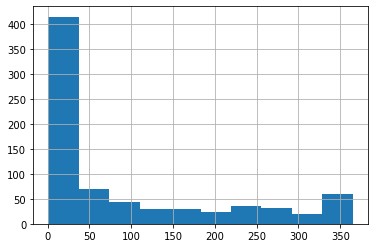

In [27]:
df[['flight_number_i', 'origin_code_i', 'destination_code_i', 'airline']].value_counts().hist()

Most of the flights are not so frequently. For example, the flight LATAM 9956 from SCEL to SPJC only occurs once in the dataset, while the flight Sky Airline 7 from SCEL to SCCI occurs 365 times in the dataset. Maybe the frequency of the flight might be correlated with delay, but we'll check it later.

In [9]:
(df['flight_number_i'] == df['flight_number_o']).value_counts(normalize=True)

True     0.933745
False    0.066255
dtype: float64

Another unexpected finding is that almost 7% of all flights have operationing flight number that is different than the schedulled (or programmed) flight number. But differently than the previous finding, this behavior may be correlated to flight delay.

In [10]:
(df['destination_code_i'] == df['destination_code_o']).value_counts()

True     68178
False       28
dtype: int64

Another very unexpected finding is that there are 28 flights whose destination city code is different than the programmed one. This also may be correlated to flight delay, but as it's a very rare behavior, it should not be a strong feature to predict flight delay.

In [11]:
(df['airline_code_i'] == df['airline_code_o']).value_counts(normalize=True)

True     0.726285
False    0.273715
dtype: float64

Yet another unexpected finding is that 27% of the flights are operated by a different airline than scheduled. We'll find later if this behavior is correlated to flight delay.

In [15]:
df['airline'].value_counts(normalize=True)

Grupo LATAM                 0.599537
Sky Airline                 0.209630
Aerolineas Argentinas       0.028575
Copa Air                    0.027124
Latin American Wings        0.024543
Avianca                     0.016890
JetSmart SPA                0.016054
Gol Trans                   0.011817
American Airlines           0.011099
Air Canada                  0.008284
Iberia                      0.005307
Delta Air                   0.005249
Air France                  0.005249
Aeromexico                  0.005146
United Airlines             0.004912
Oceanair Linhas Aereas      0.004091
Alitalia                    0.003797
K.L.M.                      0.003680
British Airways             0.003006
Qantas Airways              0.002859
Lacsa                       0.001349
Austral                     0.001085
Plus Ultra Lineas Aereas    0.000718
Name: airline, dtype: float64

The vast majority of the flights are operated by south american airlines, and LATAM alone sums up to almost 60% of the flights.

In [19]:
df['periodo_dia'].value_counts()

tarde     25506
mañana    25352
noche     17348
Name: periodo_dia, dtype: int64

As expected, there are less flights taking off at night

In [20]:
df['month'].value_counts(normalize=True)

12    0.093188
1     0.089552
11    0.089142
10    0.088438
7     0.087852
8     0.084215
9     0.082251
2     0.081532
3     0.080374
5     0.076826
4     0.073601
6     0.073029
Name: month, dtype: float64

An interesting finding is that October and November have more flights in operation than February, July and September, opposed to what `temporada_alta` suggests.

In [23]:
df['week_day'].value_counts(normalize=True)

Friday       0.150896
Thursday     0.150295
Monday       0.148535
Sunday       0.143624
Wednesday    0.142539
Tuesday      0.141659
Saturday     0.122453
Name: week_day, dtype: float64

There is no significant difference between days of week when comparing number of flights, except Saturday that is 15% smaller than average, but there is no reason so far to expect that this behavior is correlated to flight delay.

### Analysing the data

2. Create additional columns and export them in `synthetic_features.csv`

Already done in `creating_synthetic_features` and `saving_synthetic_features` functions. This file is in the folder `data`.

### Analysing the data

3. How is delay rate composed by destination, airline, month, day of week, season (*temporada_alta*) and flight type? What features would you expect to better predict delay?


In [73]:
aux_df = pd.DataFrame(index=df['destination_code_i'].unique(), columns=['flight_number', 'delay_number', 'delay_rate'])
aux_df['flight_number'] = df[['destination_code_i', 'atraso_15']].groupby('destination_code_i').count()
aux_df['delay_number'] = df[['destination_code_i', 'atraso_15']].groupby('destination_code_i').sum()
aux_df['delay_rate'] =  100 * (aux_df['delay_number'] / aux_df['flight_number'])
aux_df = aux_df.sort_values(by='delay_rate', ascending=False)
aux_df = aux_df.loc[aux_df['flight_number'] > 30, :]
aux_df.head(10)

,flight_number,delay_number,delay_rate
YSSY,195,113,57.948718
YMML,38,21,55.263158
SAAR,136,54,39.705882
NZAA,361,135,37.396122
MDPC,54,18,33.333333
CYYZ,283,89,31.448763
SACO,1023,308,30.107527
SGAS,232,66,28.448276
SBGL,1434,405,28.242678
SAME,1625,443,27.261538


In [70]:
aux_df.tail(10)

,flight_number,delay_number,delay_rate
LIRF,259,29,11.196911
SAZN,37,4,10.810811
MMMX,700,66,9.428571
SCNT,79,7,8.860759
LFPG,359,31,8.635097
SCPQ,235,18,7.659574
KDFW,357,25,7.002801
MPTO,1850,116,6.270270
KATL,358,21,5.865922
KIAH,335,17,5.074627


In [48]:
100*(1 - aux_df['flight_number'].sum()/len(df))

0.03518752015951865

<AxesSubplot:>

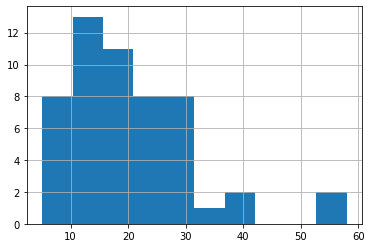

In [50]:
aux_df['delay_rate'].hist()

In [ ]:
1 - aux_df[aux_df['flight_number'] > 200]['flight_number'].sum()/len(df)

We're using `destination_code_i` because there are only 28 flights in which `destination_code_o` is different than `destination_code_i`, so the analysis and it's conclusion should be the same despite the destination code used.

In order to better understand delay behavior by destination, we ignored all destination cities that receives less than 30 flights. It does not compromise the analysis as it represents only 0.03% of all flight records.

We see that there are cities with almost 60% of flight delay rate. It may be an outlier, as those cities have less than 200 flight records and all cities that receives less than 200 flights sums up to only 1.7% of all flights. So we will ignore all cities that receives less than 350 flights.

0.017153916077764397